In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

# Enable GPU dynamic memory allocation
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

tf.get_logger().setLevel('ERROR') 
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_CFG = "out_model/faster_rcnn/pipeline.config"
PATH_CKPT = "out_model/faster_rcnn"
CKPT = "ckpt-3"
PATH_LABELS = "annotation/label_map.pbtxt"
PATH_IMAGES = "images_inf/raw"

In [2]:
print('Loading model... ', end='')
start_time = time.time()

# load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_CKPT, CKPT)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.5883643627166748 seconds


In [3]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_LABELS)
category_index

{1: {'id': 1, 'name': 'hibiscus'},
 2: {'id': 2, 'name': 'popukar'},
 3: {'id': 3, 'name': 'melantha'},
 4: {'id': 4, 'name': 'lava'},
 5: {'id': 5, 'name': 'midnight'},
 6: {'id': 6, 'name': 'spot'},
 7: {'id': 7, 'name': 'cardigan'},
 8: {'id': 8, 'name': 'beagle'},
 9: {'id': 9, 'name': 'steward'},
 10: {'id': 10, 'name': 'plume'},
 11: {'id': 11, 'name': 'orchid'},
 12: {'id': 12, 'name': 'ansel'},
 13: {'id': 13, 'name': 'vanilla'},
 14: {'id': 14, 'name': 'fang'},
 15: {'id': 15, 'name': 'kroos'},
 16: {'id': 16, 'name': 'catapult'}}

In [4]:
%matplotlib notebook
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import warnings
from operator import itemgetter

def load_image_into_numpy_array(img):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(img)

def load_image(img):
    size = (1280, 640)
    left = (0, 0, 640, 640)
    right = (640, 0, 1280, 640)
    
    img = img.convert('RGB')
    img = img.resize(size)
    
    return (img.crop(left), img.crop(right))

THRESHOLD = .5

warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

for i, img in enumerate(os.listdir(PATH_IMAGES)):
    image_path = os.path.join(PATH_IMAGES, img)
    print('Running inference for {} with threshold of {}... '.format(image_path, THRESHOLD), end='')
    
    img = Image.open(image_path)
    img = load_image(img)
    for im in img:
        image_np = load_image_into_numpy_array(im)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np,0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        detections['num_detections'] = num_detections

        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=100,
            min_score_thresh=THRESHOLD,
            agnostic_mode=False)

        plt.figure(figsize=(8,6))
        plt.imshow(image_np_with_detections)
        print('Done')

Running inference for images_inf/raw\1651165331840.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


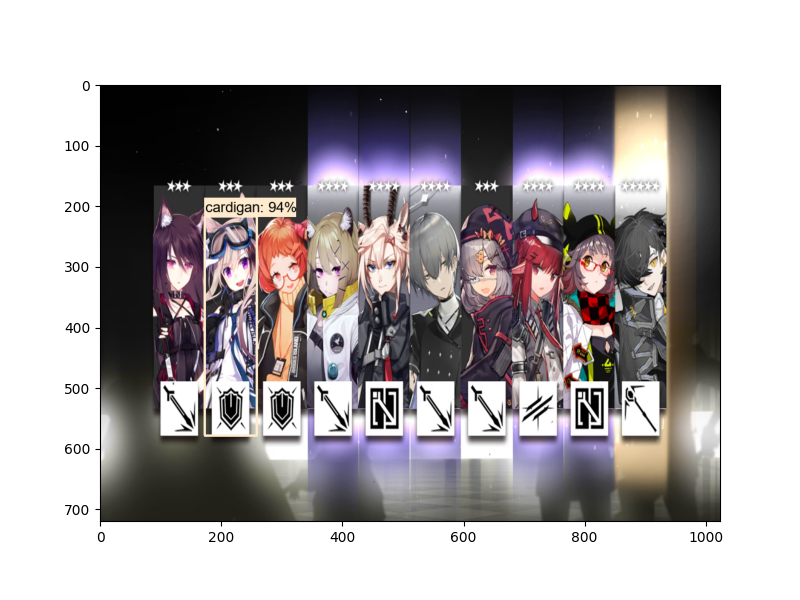

Done
Running inference for images_inf/raw\1651165341389.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


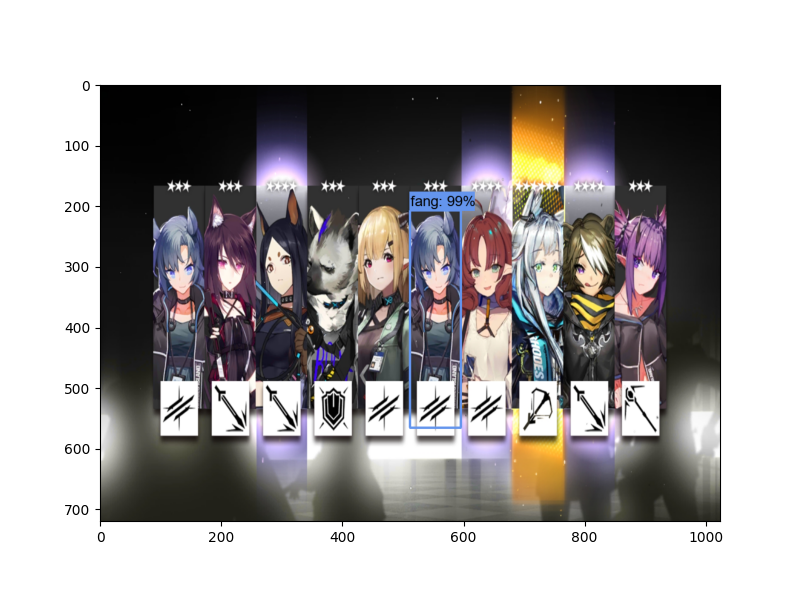

Done
Running inference for images_inf/raw\1651165559950.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


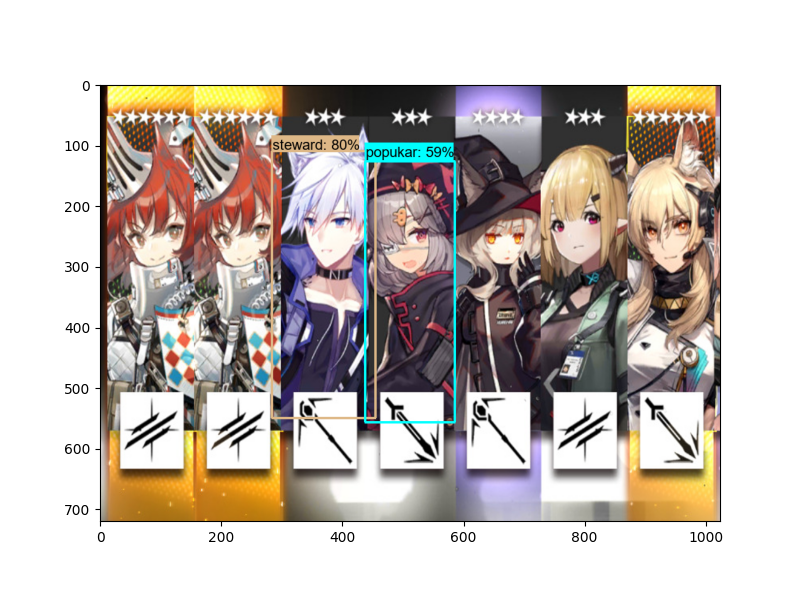

Done
Running inference for images_inf/raw\1651165612798.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


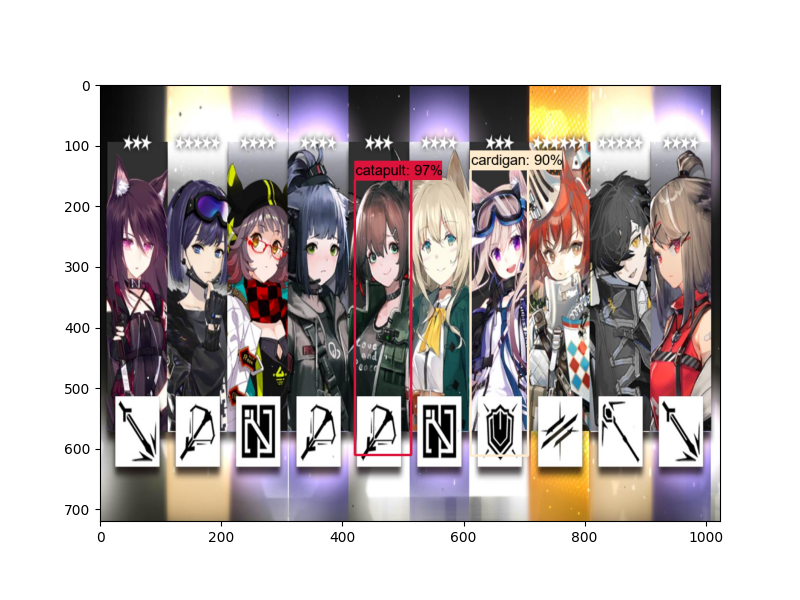

Done
Running inference for images_inf/raw\1651166047758.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


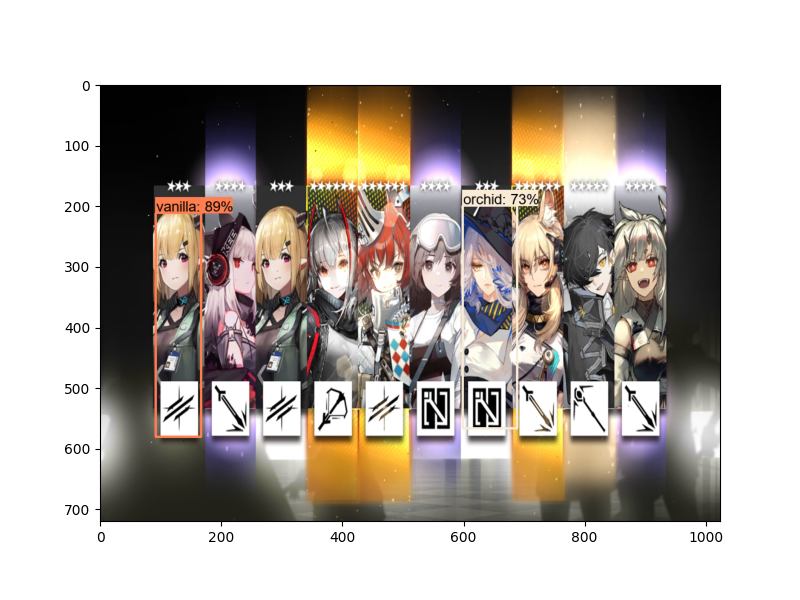

Done
Running inference for images_inf/raw\2y0hFl6.jpeg with threshold of 0.5... 

<IPython.core.display.Javascript object>


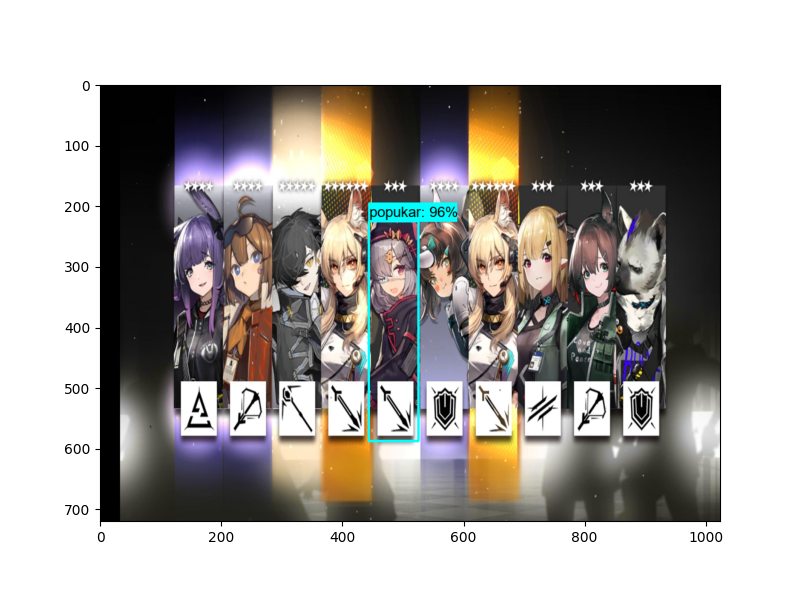

Done
Running inference for images_inf/raw\arknights-discount-pull.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


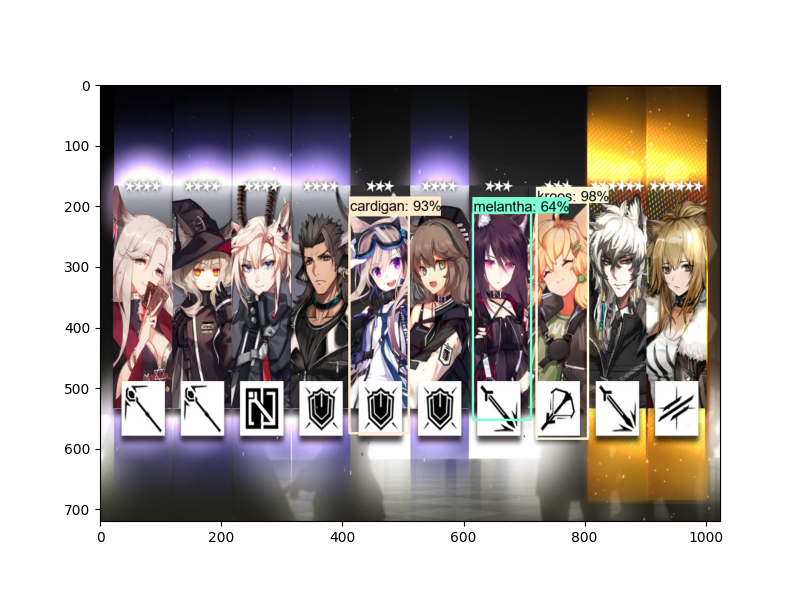

Done
Running inference for images_inf/raw\D0cHa3D.jpeg with threshold of 0.5... 

<IPython.core.display.Javascript object>


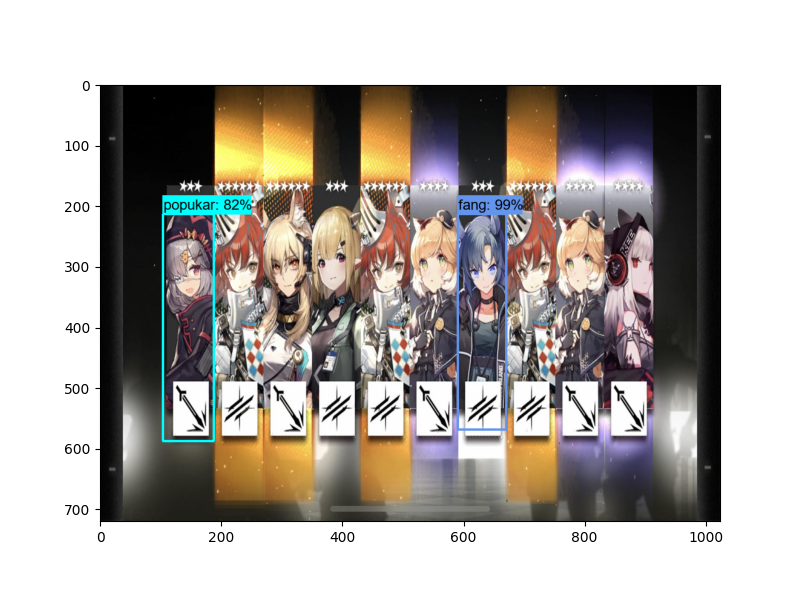

Done
Running inference for images_inf/raw\oVcEpND.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


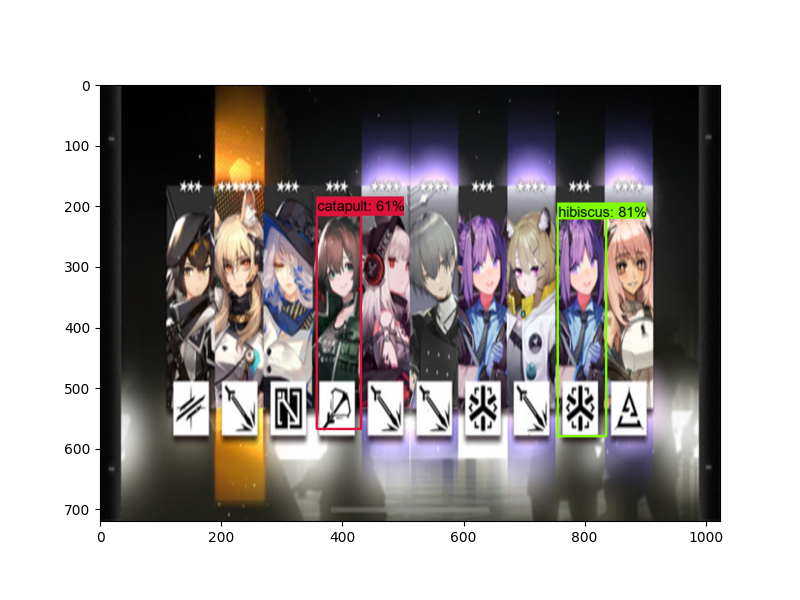

Done
Running inference for images_inf/raw\pull_1.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


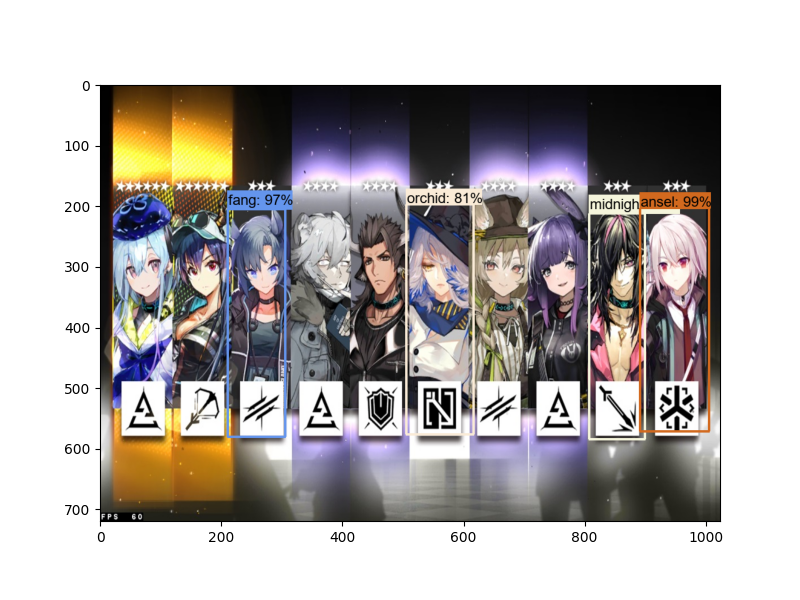

Done
Running inference for images_inf/raw\pull_2.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


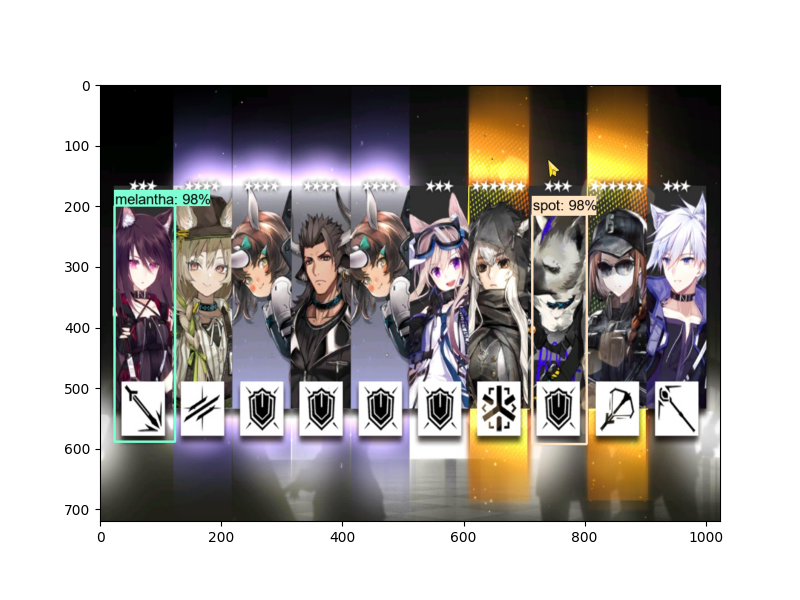

Done
Running inference for images_inf/raw\swtSedm.jpg with threshold of 0.5... 

<IPython.core.display.Javascript object>


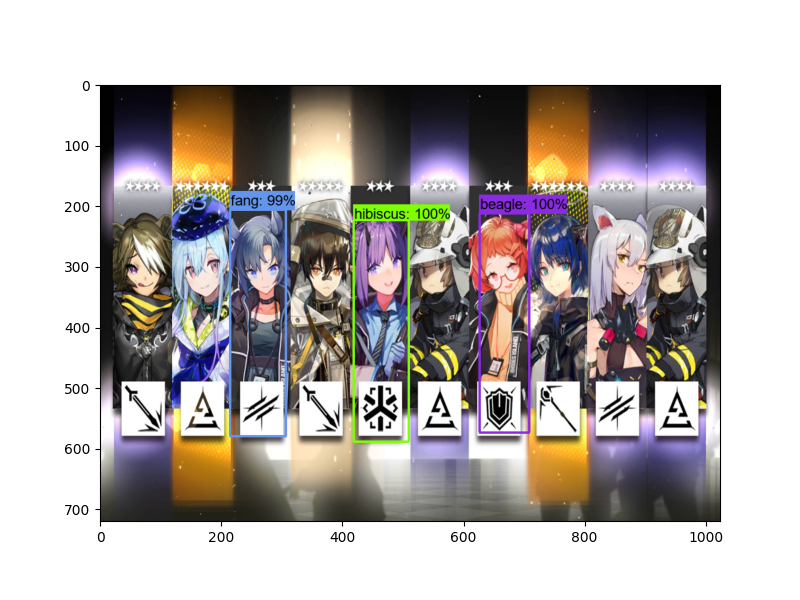

Done


In [8]:
for i, img in enumerate(os.listdir(PATH_IMAGES)):
    image_path = os.path.join(PATH_IMAGES, img)
    print('Running inference for {} with threshold of {}... '.format(image_path, THRESHOLD), end='')
    
    img = Image.open(image_path)
    img = img.resize((1024,720))
    image_np = load_image_into_numpy_array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np,0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        min_score_thresh=THRESHOLD,
        agnostic_mode=False)

    plt.figure(figsize=(8,6))
    plt.imshow(image_np_with_detections)
    print('Done')

In [23]:
plt.show()

In [24]:
from operator import itemgetter

def score_lists(detections):
#Create indexes list of element with a score > 0.5
    indexes = [k for k,v in enumerate(detections['detection_scores']) if (v > THRESHOLD)]

    #Number of entities
    num_entities = len(indexes)

    #Extract the class id
    try:
        class_id = itemgetter(*indexes)(detections['detection_classes']+1)
    except:
        return 'no image found'
    scores = itemgetter(*indexes)(detections['detection_scores'])

    #Convert the class id in their name
    class_names = []
    if num_entities == 1:
        class_names.append(category_index[class_id]['name'])
        class_name = str(class_names)
    else:
        for i in range(0, len(indexes)):
            class_names.append(category_index[class_id[i]]['name'])

    print(indexes)
    print(class_id)
    print(scores)
    print(class_names)
    
score_lists(detections)

'no image found'